# 🌍 AirQo PM2.5 Prediction Pipeline

## Project Overview
This notebook implements a production-ready machine learning pipeline to forecast **Particulate Matter (PM2.5)** concentrations across African cities using satellite-derived observations. 

### Workflow Steps:
1.  **Data Loading & Cleaning**: Ingestion and target outlier removal.
2.  **EDA**: analyzing distributions and correlations.
3.  **Preprocessing**: Custom feature engineering (Time extraction, Outlier clipping).
4.  **Modeling**: Training a LightGBM regressor within a Scikit-Learn Pipeline.
5.  **Experiment Tracking**: Logging metrics and artifacts using **MLflow**.
6.  **Inference**: Generating predictions for the test set.

---

## 1. Setup and Configuration
We start by importing necessary libraries and defining a `Config` class to centralize all hyperparameters and file paths.

In [77]:
import os
import joblib
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

from pathlib import Path
from typing import List, Tuple
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
from typing import List, Literal


# Set plotting style
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 50)

In [78]:
class Config:
    # --- Paths ---
    # Update these paths if your data is located elsewhere
    BASE_DIR = Path.cwd().parent
    DATA_DIR = BASE_DIR / "data" / "raw"
    RAW_DATA_PATH = DATA_DIR / "Train.csv"  # Assumes file is in current directory or adjust path
    TEST_DATA_PATH = DATA_DIR / "Test.csv"
    MODEL_DIR = BASE_DIR / "models" / "artifacts"
    MLFLOW_URI = f"file://{BASE_DIR / 'models' / 'mlruns'}"
    FIGURES_DIR = BASE_DIR / "reports" / "figures"

    # --- Experiment Configs ---
    EXPERIMENT_NAME = "airqo_pm25_prediction"
    
    # --- Data Config ---
    TARGET = "pm2_5"
    ID_COL = "id"
    # Columns to drop (high cardinality or irrelevant for training)
    DROP_COLS = ["id","site_id", "site_latitude", "site_longitude", "city", "country"]
    DATE_COL = "date"
    
    # --- Hyperparameters ---
    OUTLIER_QUANTILE = 0.02
    RANDOM_STATE = 42
    MODEL_TYPE = 'lgbm'
    TIME_FEATURES = ["month", "week", "day_of_week", "hour"]
    CORRELATION_THRESH = 0.85
    MISSING_THRESH = 0.5

# Create directories
os.makedirs(Config.MODEL_DIR, exist_ok=True)
os.makedirs(Config.FIGURES_DIR, exist_ok=True)
print("✅ Configuration loaded and directories created.")

✅ Configuration loaded and directories created.


---

## 2. Data Loading & Cleaning
We define functions to load the data and remove extreme outliers from the target variable (`pm2_5`). This helps stabilize the model training.

In [79]:
def load_data(path: str) -> pd.DataFrame:
    """Loads CSV data safely."""
    try:
        df = pd.read_csv(path)
        print(f"✅ Loaded data from {path}: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"❌ File not found at {path}. Please check your path.")
        return None

def clean_target_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """Removes rows where target is outside specific quantiles."""
    upper = df[Config.TARGET].quantile(1 - Config.OUTLIER_QUANTILE)
    lower = df[Config.TARGET].quantile(Config.OUTLIER_QUANTILE)
    
    initial_len = len(df)
    df_clean = df[(df[Config.TARGET] > lower) & (df[Config.TARGET] < upper)].reset_index(drop=True)
    
    print(f"🧹 Removed {initial_len - len(df_clean)} target outliers (Boundaries: {lower:.2f} - {upper:.2f}).")
    return df_clean

# Load and clean the training data
df_train = load_data(Config.RAW_DATA_PATH)
if df_train is not None:
    df_train_clean = clean_target_outliers(df_train)
    df_train_clean.head()

✅ Loaded data from /mnt/work/SAIR/airqo_pipeline/data/raw/Train.csv: (8071, 80)
🧹 Removed 324 target outliers (Boundaries: 5.87 - 74.32).


---

## 3. Exploratory Data Analysis (EDA)
Before training, we visualize the target distribution and feature correlations to understand the data landscape.

### 3.1 Target Distribution

In [80]:
def save_regression_plot(y_true, y_pred, saving_dir):
    """Plots y_true vs y_pred with a regression fit line and RMSE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predictions')
    
    # Calculate regression line fit (y = mx + c)
    m, c = np.polyfit(y_true, y_pred, 1)
    plt.plot(y_true, m*y_true + c, color='red', label=f'Fit Line (m={m:.2f})')
    
    plt.title(f'Actual vs Predicted (RMSE: {rmse:.4f})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Save the plot
    save_path = os.path.join(saving_dir, "regression_fit.png")
    plt.savefig(save_path)
    plt.close() # Close to free up memory
    print(f"Regression plot saved to: {save_path}")

def plot_feature_importance(pipeline, model_name):
    """Extracts and saves feature importance using automatic name discovery."""
    
    # 1. Get the names from the preprocessing steps
    # We slice [:-1] to get everything EXCEPT the regressor
    preprocessor_part = pipeline[:-1]
    feature_names = preprocessor_part.get_feature_names_out()
    
    # 2. Get the model (the last step)
    model = pipeline.steps[-1][1]
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # 3. Create DataFrame
        feat_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(10)

        # 4. Plotting
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feat_df, x='Importance', y='Feature', hue='Feature')
        plt.title(f'Top 10 Features - {model_name}')
        # plt.yticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Model {model_name} does not support feature importances.")

Target stats: mu = 22.60 and sigma = 13.27


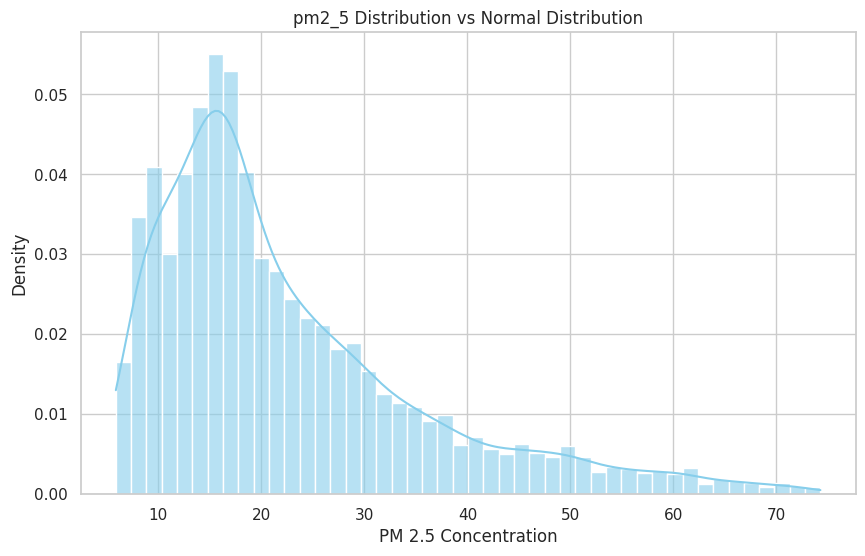

In [81]:
def plot_target_distribution(data, target):
    from scipy.stats import norm
    plt.figure(figsize=(10, 6))
    sns.histplot(data[target], kde=True, stat="density", color="skyblue", alpha=0.6)
    
    # Fit a normal distribution
    (mu, sigma) = norm.fit(data[target])
    print(f'Target stats: mu = {mu:.2f} and sigma = {sigma:.2f}')
    
    plt.title(f'{target} Distribution vs Normal Distribution')
    plt.xlabel('PM 2.5 Concentration')
    plt.show()

if df_train is not None:
    plot_target_distribution(df_train_clean, Config.TARGET)

### 3.2 Feature Correlations

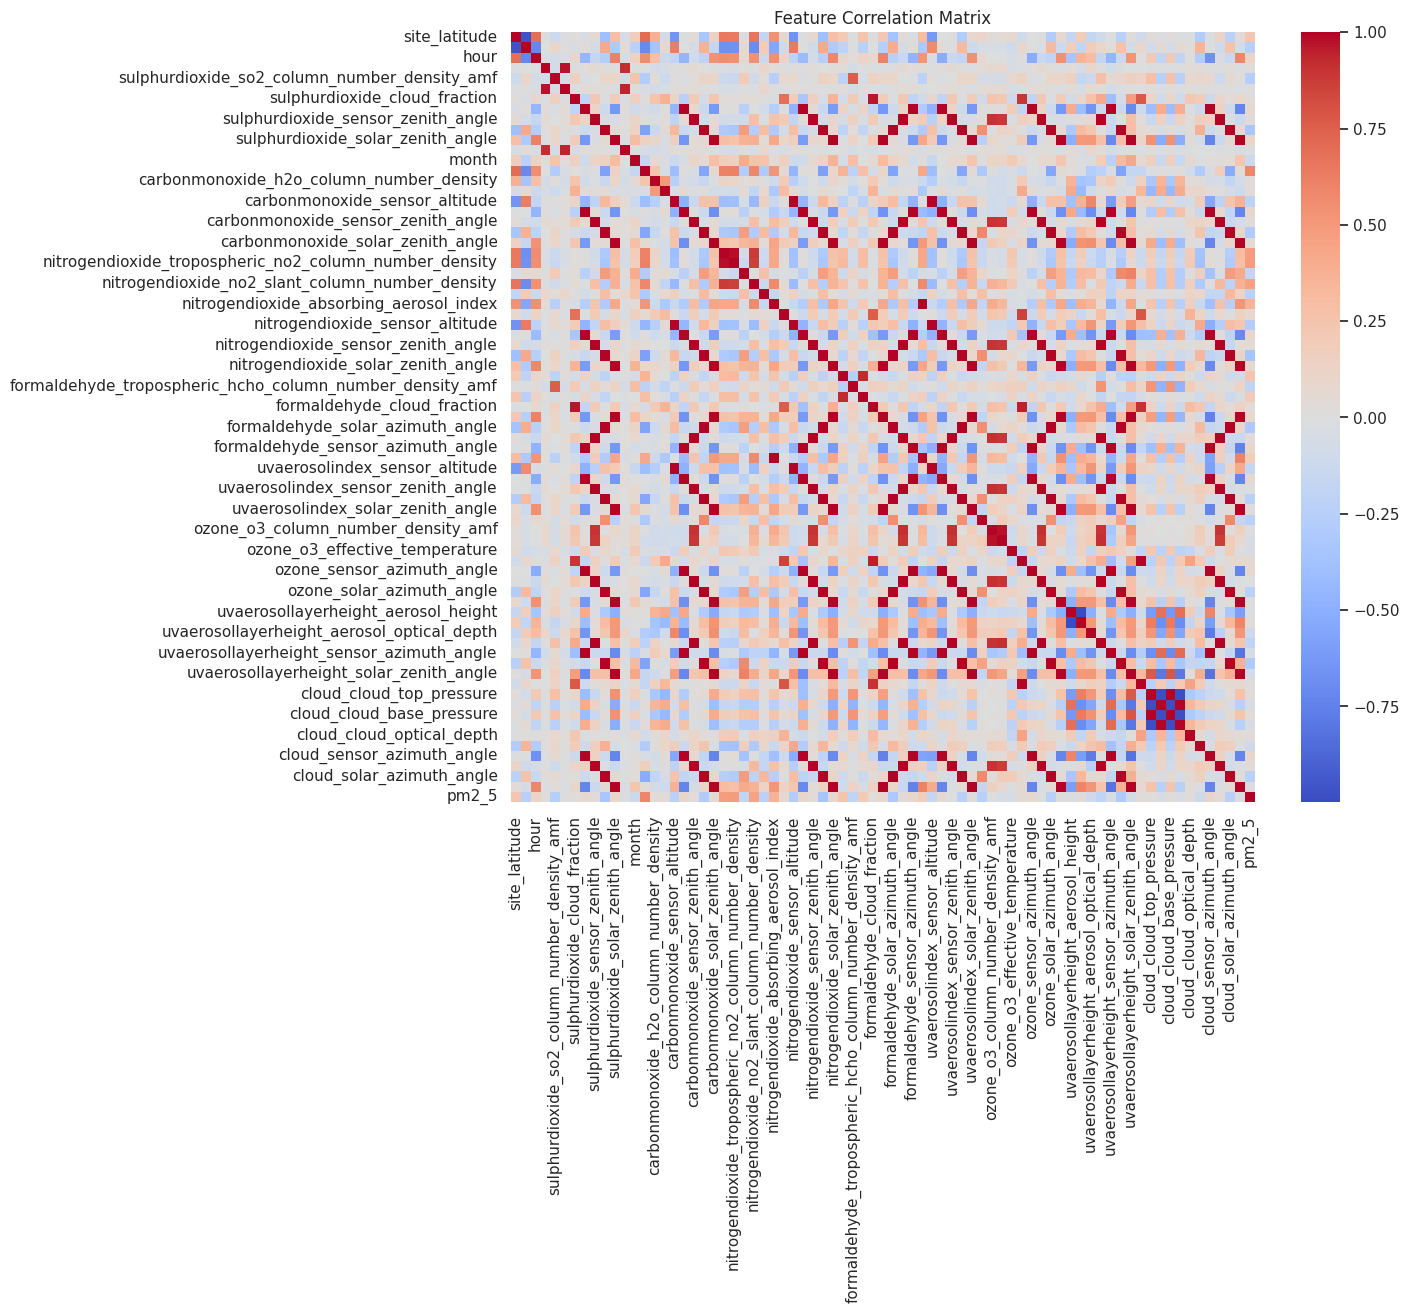

In [82]:
def plot_correlations(data):
    # Select only numeric columns
    num_data = data.select_dtypes(include=[np.number])
    
    plt.figure(figsize=(12, 10))
    corr = num_data.corr()
    sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f")
    plt.title("Feature Correlation Matrix")
    plt.show()

if df_train is not None:
    plot_correlations(df_train_clean)

---

## 4. Custom Transformers & Pipeline
We implement modular Scikit-Learn transformers to handle:
1.  **Time Extraction**: Converting date strings into features like `month`, `hour`, etc.
2.  **Outlier Handling**: Clipping feature values to reduce noise.

These are integrated into a `Pipeline` to ensure no data leakage occurs.

In [83]:
# --- 4.1 Time Feature Extractor ---
class TimeFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extracts temporal features and handles feature name propagation."""
    def __init__(self, date_col: str, features_to_extract: List[str] = None):
        self.date_col = date_col
        self.features_to_extract = features_to_extract or ["month", "hour"]

    def fit(self, X: pd.DataFrame, y=None):
        self.feature_names_in_ = np.array(X.columns.tolist())
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_out = X.copy()
        X_out[self.date_col] = pd.to_datetime(X_out[self.date_col])
        
        if "month" in self.features_to_extract:
            X_out[f"{self.date_col}_month"] = X_out[self.date_col].dt.month
        if "hour" in self.features_to_extract:
            X_out[f"{self.date_col}_hour"] = X_out[self.date_col].dt.hour
        if "week" in self.features_to_extract:
            X_out[f"{self.date_col}_week"] = X_out[self.date_col].dt.isocalendar().week.astype(int)
        if "day_of_week" in self.features_to_extract:
            X_out[f"{self.date_col}_dow"] = X_out[self.date_col].dt.dayofweek
        
        return X_out.drop(columns=[self.date_col])

    def get_feature_names_out(self, input_features=None):
        if input_features is None: input_features = self.feature_names_in_
        features = [f for f in input_features if f != self.date_col]
        new_feats = [f"{self.date_col}_{t}" for t in self.features_to_extract if t in ["month", "hour", "week", "day_of_week"]]
        return np.array(features + new_feats)


# --- 4.2 High Missing Dropper ---
class HighMissingDropper(BaseEstimator, TransformerMixin):
    """Drops columns with missing percentage above a threshold."""
    def __init__(self, threshold: float = 0.5):
        self.threshold = threshold
        self.drop_cols_ = []

    def fit(self, X: pd.DataFrame, y=None):
        # Calculate missing percentage per column
        missing_frac = X.isnull().mean()
        self.drop_cols_ = missing_frac[missing_frac > self.threshold].index.tolist()
        print(f"\n🗑️ HighMissingDropper: Will drop {len(self.drop_cols_)} columns > {self.threshold*100}% missing.")
        self.feature_names_in_ = np.array(X.columns.tolist())
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # Drop identified columns
        return X.drop(columns=self.drop_cols_, errors='ignore')

    def get_feature_names_out(self, input_features=None):
        if input_features is None: input_features = self.feature_names_in_
        return np.array([f for f in input_features if f not in self.drop_cols_])


# --- 4.3 Correlated Feature Aggregator ---
class CorrelatedFeatureAggregator(BaseEstimator, TransformerMixin):
    """
    Automatically groups correlated features (> threshold) using a graph-based approach,
    replaces them with their mean, and drops the originals.
    """
    def __init__(self, threshold: float = 0.85):
        self.threshold = threshold
        self.groups_ = {} # Maps new_name -> [list_of_cols]
        self.drop_cols_ = []

    def fit(self, X: pd.DataFrame, y=None):
        self.feature_names_in_ = np.array(X.columns.tolist())
        
        # Only consider numeric columns for correlation
        num_cols = X.select_dtypes(include=[np.number]).columns
        
        if len(num_cols) < 2:
            return self

        # 1. Compute Correlation Matrix
        corr_matrix = X[num_cols].corr().abs()
        
        # 2. Find Connected Components (Groups)
        # We treat features as nodes and high correlation as edges.
        processed = set()
        group_id = 1
        
        for col in num_cols:
            if col in processed:
                continue
            
            # Find all features connected to 'col' (including itself)
            group = [col]
            stack = [col]
            processed.add(col)
            
            while stack:
                current = stack.pop()
                # Get neighbors with corr > threshold
                neighbors = corr_matrix[current][corr_matrix[current] > self.threshold].index.tolist()
                for neighbor in neighbors:
                    if neighbor not in processed:
                        processed.add(neighbor)
                        stack.append(neighbor)
                        group.append(neighbor)
            
            # If group has more than 1 feature, save it
            if len(group) > 1:
                new_name = f"agg_corr_group_{group_id}"
                self.groups_[new_name] = group
                self.drop_cols_.extend(group)
                group_id += 1
                
        print(f"🔗 CorrelatedFeatureAggregator: Found {len(self.groups_)} groups to aggregate (Threshold: {self.threshold}).")
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_out = X.copy()
        
        # Create aggregated mean columns
        for new_col, components in self.groups_.items():
            # Compute mean row-wise
            X_out[new_col] = X_out[components].mean(axis=1)
            
        # Drop original columns
        return X_out.drop(columns=self.drop_cols_, errors='ignore')

    def get_feature_names_out(self, input_features=None):
        if input_features is None: input_features = self.feature_names_in_
        # Remove dropped, add new
        kept = [f for f in input_features if f not in self.drop_cols_]
        new = list(self.groups_.keys())
        return np.array(kept + new)


# --- 4.4 Outlier Handler ---
class OutlierHandler(BaseEstimator, TransformerMixin):
    """Clips outliers using IQR method."""
    def __init__(self, factor: float = 1.5):
        self.factor = factor
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

    def fit(self, X: pd.DataFrame, y=None):
        self.feature_names_in_ = np.array(X.columns.tolist())
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.lower_bounds_[col] = Q1 - (self.factor * IQR)
            self.upper_bounds_[col] = Q3 + (self.factor * IQR)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_out = X.copy()
        for col, lower in self.lower_bounds_.items():
            if col in X_out.columns:
                upper = self.upper_bounds_[col]
                X_out[col] = np.clip(X_out[col], lower, upper)
        return X_out

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_in_

class SmartColumnDropper(BaseEstimator, TransformerMixin):
    """
    A transformer that safely drops or keeps columns based on a strategy.
    
    Parameters:
    -----------
    columns : List[str]
        The list of columns to act upon.
    strategy : 'drop' or 'keep', default='drop'
        'drop': Removes the specified columns from the dataframe.
        'keep': Keeps ONLY the specified columns, dropping everything else.
    """
    def __init__(self, columns: List[str], strategy: Literal['drop', 'keep'] = 'drop'):
        self.columns = columns
        self.strategy = strategy
        self.feature_names_in_ = None
        self.final_columns_ = None

    def fit(self, X: pd.DataFrame, y=None):
        self.feature_names_in_ = np.array(X.columns.tolist())
        
        if self.strategy == 'drop':
            # Check for columns requested to drop that aren't there
            missing_cols = [c for c in self.columns if c not in X.columns]
            if missing_cols:
                warnings.warn(
                    f"⚠️ SmartColumnDropper (drop): Columns not found to drop: {missing_cols}"
                )
            self.final_columns_ = [c for c in X.columns if c not in self.columns]
            
        elif self.strategy == 'keep':
            # Check for columns requested to keep that aren't there
            missing_cols = [c for c in self.columns if c not in X.columns]
            if missing_cols:
                warnings.warn(
                    f"⚠️ SmartColumnDropper (keep): Columns requested to keep but missing from input: {missing_cols}"
                )
            # We can only keep what actually exists
            self.final_columns_ = [c for c in self.columns if c in X.columns]
            
        else:
            raise ValueError("Strategy must be either 'drop' or 'keep'.")
            
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # Use the columns identified during fit
        return X[self.final_columns_].copy()

    def get_feature_names_out(self, input_features=None):
        """
        Returns the names of the features that remain after the transformation.
        """
        return np.array(self.final_columns_)

In [84]:
# --- 4.5 Pipeline Construction ---

def build_pipeline(cat_cols: list, num_cols: list) -> Pipeline:
    """Constructs the full processing and modeling pipeline."""
    
    # Model Registry
    MODELS = {
        "lgbm": LGBMRegressor(verbose=-1, random_state=Config.RANDOM_STATE),
        "xgboost": XGBRegressor(random_state=Config.RANDOM_STATE),
        "rf": RandomForestRegressor(random_state=Config.RANDOM_STATE)
    }

    # 1. Feature Engineering (Applied sequentially)
    # Note: These transformers handle dataframe input/output
    feature_engineering = Pipeline([
        ("column_filterer", SmartColumnDropper(Config.DROP_COLS)),
        ('corr_aggregator', CorrelatedFeatureAggregator(threshold=Config.CORRELATION_THRESH)),
        ('missing_dropper', HighMissingDropper(threshold=Config.MISSING_THRESH)),
        ('time_extractor', TimeFeatureExtractor(date_col=Config.DATE_COL, features_to_extract=Config.TIME_FEATURES)),
        ('outlier_clipper', OutlierHandler(factor=1.5)),
    ])
    
    # 2. Column Preprocessing (Handling missing values & scaling)
    # NOTE: Since feature_engineering changes columns dynamically, we cannot rely on 
    # fixed lists 'num_cols' passed at the start. 
    # We must use 'make_column_selector' to select columns dynamically after feature engineering.
    from sklearn.compose import make_column_selector

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ])
    
    # 3. Final Assembly
    pipeline = Pipeline([
        ('feature_eng', feature_engineering),
        ('preprocessor', preprocessor),
        ('regressor', MODELS[Config.MODEL_TYPE])
    ])
    
    return pipeline

---

## 5. Model Training & Validation
We use a custom validation strategy based on cities to ensure the model generalizes well to new locations. We also use **MLflow** to track the experiment.

In [85]:
# --- 5.1 Helper Functions ---

def get_train_val_folds(X):
    """Generates folds based on city combinations to test spatial generalization."""
    def get_all_combinations(input_list):
        all_combinations = []
        for r in range(1, len(input_list)):
            all_combinations.extend(list(itertools.combinations(input_list, r)))
        return all_combinations

    unique_cities = X['city'].unique()
    folds = {}
    
    # Simplified for notebook demo: Taking limited combinations to save time
    # In production, use the full list from ingest.py
    combos = get_all_combinations(unique_cities.tolist())
    
    for i, cities in enumerate(combos):
        train_mask = X['city'].isin(cities)
        # Ensure meaningful split size (e.g. valid set is smaller than train)
        if len(X[train_mask]) < len(X[~train_mask]):
            continue
            
        folds[i] = (X[train_mask].index.values, X[~train_mask].index.values)
        
    print(f"Created {len(folds)} validation folds based on city splits.")
    return folds

def evaluate_metrics(y_true, y_pred):
    return {
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "r2": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred)
    }

def plot_results(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, color='purple')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual PM2.5')
    plt.ylabel('Predicted PM2.5')
    plt.title('Actual vs Predicted')
    plt.show()

In [86]:
# --- 5.2 Main Training Workflow ---

def train_workflow(df):
    # Setup MLflow
    mlflow.set_tracking_uri(Config.MLFLOW_URI)
    mlflow.set_experiment(Config.EXPERIMENT_NAME)
    
    # Prepare Data
    X = df.drop(columns=[Config.TARGET])
    y = df[Config.TARGET]
    
    # Define Folds
    folds = get_train_val_folds(df)
    
    # Define Column types for Pipeline
    # Exclude Drop Cols & Date Col (handled by transformer)
    features = [c for c in X.columns if c not in Config.DROP_COLS and c != Config.DATE_COL]
    cat_cols = X[features].select_dtypes(exclude=['number']).columns.tolist()
    num_cols = X[features].select_dtypes(include=['number']).columns.tolist()
    # Note: We pass 'num_cols' here, but our custom transformer adds time features.
    # In a stricter pipeline, we would use sklearn's make_column_selector.
    # For this notebook, we assume the numeric transformer handles the raw numeric cols.
    pipeline = build_pipeline(cat_cols, num_cols)
    
    print("\n🚀 Starting Training Run...")
    
    with mlflow.start_run(run_name="notebook_run"):
        
        # Cross Validation Loop
        all_metrics = []
        preds = np.zeros(len(y))
        preds_counts = np.zeros(len(y))
        
        for fold_id, (train_idx, val_idx) in folds.items():
            X_train, X_val = X.iloc[train_idx,:], X.iloc[val_idx,:]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_val)
            
            metrics = evaluate_metrics(y_val, y_pred)
            all_metrics.append(metrics)
            
            # Accumulate for OOF predictions
            preds[val_idx] += y_pred
            preds_counts[val_idx] += 1
            
        # Aggregate Metrics
        avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
        print(f"✅ Cross-Validation Metrics: {avg_metrics}")
        
        # Log to MLflow
        mlflow.log_params(pipeline.named_steps['regressor'].get_params())
        mlflow.log_metrics(avg_metrics)
        
        # Train on Full Dataset and Save
        pipeline.fit(X, y)
        joblib.dump(pipeline, Config.MODEL_DIR / "final_pipeline.pkl")
        mlflow.sklearn.log_model(pipeline, "model")
            
    return pipeline

if df_train is not None:
    trained_pipeline = train_workflow(df_train_clean)

Created 7 validation folds based on city splits.

🚀 Starting Training Run...
🔗 CorrelatedFeatureAggregator: Found 12 groups to aggregate (Threshold: 0.85).

🗑️ HighMissingDropper: Will drop 8 columns > 50.0% missing.


/home/ibrahim/work/SAIR/airqo_pipeline/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


🔗 CorrelatedFeatureAggregator: Found 12 groups to aggregate (Threshold: 0.85).

🗑️ HighMissingDropper: Will drop 7 columns > 50.0% missing.


/home/ibrahim/work/SAIR/airqo_pipeline/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


🔗 CorrelatedFeatureAggregator: Found 12 groups to aggregate (Threshold: 0.85).

🗑️ HighMissingDropper: Will drop 9 columns > 50.0% missing.


/home/ibrahim/work/SAIR/airqo_pipeline/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


🔗 CorrelatedFeatureAggregator: Found 12 groups to aggregate (Threshold: 0.85).

🗑️ HighMissingDropper: Will drop 7 columns > 50.0% missing.


/home/ibrahim/work/SAIR/airqo_pipeline/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


🔗 CorrelatedFeatureAggregator: Found 12 groups to aggregate (Threshold: 0.85).

🗑️ HighMissingDropper: Will drop 7 columns > 50.0% missing.


/home/ibrahim/work/SAIR/airqo_pipeline/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


🔗 CorrelatedFeatureAggregator: Found 12 groups to aggregate (Threshold: 0.85).

🗑️ HighMissingDropper: Will drop 7 columns > 50.0% missing.


/home/ibrahim/work/SAIR/airqo_pipeline/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


🔗 CorrelatedFeatureAggregator: Found 12 groups to aggregate (Threshold: 0.85).

🗑️ HighMissingDropper: Will drop 9 columns > 50.0% missing.


/home/ibrahim/work/SAIR/airqo_pipeline/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ Cross-Validation Metrics: {'rmse': 12.380830069262348, 'r2': 0.19068562080691295, 'mae': 9.906200564016004}
🔗 CorrelatedFeatureAggregator: Found 12 groups to aggregate (Threshold: 0.85).

🗑️ HighMissingDropper: Will drop 7 columns > 50.0% missing.


2026/01/20 08:46:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/20 08:47:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


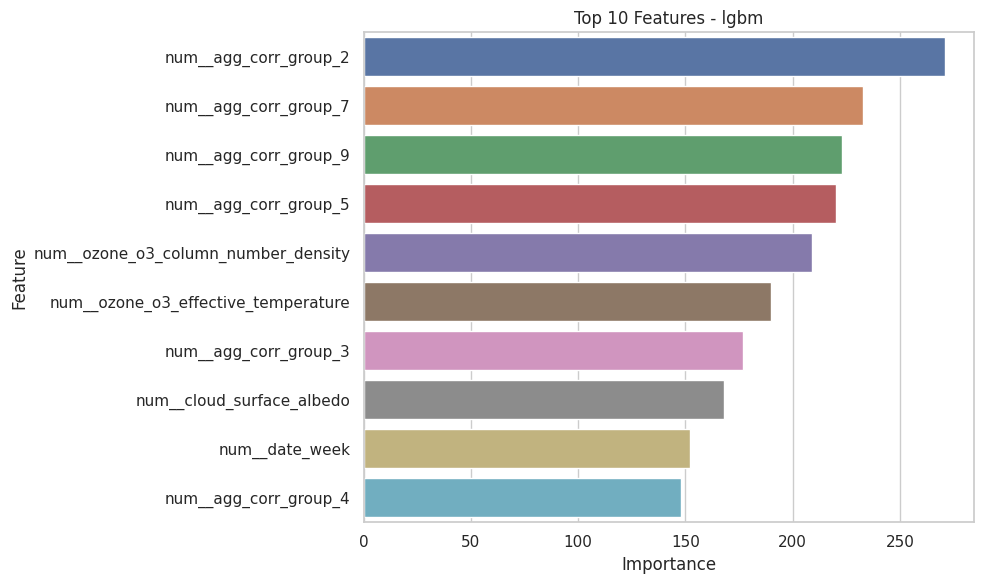

In [87]:
plot_feature_importance(trained_pipeline, Config.MODEL_TYPE)

---

## 6. Inference
Finally, we load the test dataset and generate predictions using the trained pipeline.

In [88]:
def predict_and_save(input_path, pipeline):
    try:
        df_test = pd.read_csv(input_path)
        print(f"🔍 Loaded test data: {df_test.shape}")
        
        if Config.ID_COL not in df_test.columns:
             raise ValueError(f"Missing ID column: {Config.ID_COL}")
        
        predictions = pipeline.predict(df_test)
        
        submission = pd.DataFrame({
            Config.ID_COL: df_test[Config.ID_COL],
            Config.TARGET: predictions
        })
        
        output_path = Config.DATA_DIR / "outputs" / "submission.csv"
        os.makedirs(output_path.parent, exist_ok=True)
        submission.to_csv(output_path, index=False)
        
        print(f"✅ Submission saved to {output_path}")
        return submission.head()
        
    except FileNotFoundError:
        print("⚠️ Test file not found. Skipping inference.")
        return None

if df_train is not None:
    predict_and_save(Config.TEST_DATA_PATH, trained_pipeline)

🔍 Loaded test data: (2783, 79)
✅ Submission saved to /mnt/work/SAIR/airqo_pipeline/data/raw/outputs/submission.csv


/home/ibrahim/work/SAIR/airqo_pipeline/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Conclusion
We have successfully converted a multi-script project into a single, cohesive notebook. This pipeline handles everything from raw data ingestion to MLflow tracking, ensuring a robust and reproducible machine learning workflow.